In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
import os
from torchvision import datasets, transforms

In [2]:
from google.colab import drive

In [3]:
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [7]:
!ls "/content/drive/My Drive/Deep Learning/flowers-Recognition/flowers"

daisy  dandelion  rose	sunflower  tulip


In [8]:
data_dir = r"/content/drive/My Drive/Deep Learning/flowers-Recognition/flowers"


In [9]:
flower_classes = ['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']

In [10]:
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data import DataLoader

mean = np.array([0.485, 0.456, 0.406])
std = np.array([0.229, 0.224, 0.225])
transform = transforms.Compose([transforms.Resize(255),
                                transforms.CenterCrop(224),
                                transforms.ToTensor(),
                                transforms.Normalize((0.5,), (0.5,))
                               ])
dataset = datasets.ImageFolder(data_dir, transform = transform)
num = len(dataset)
test_size = 0.3
indices = list(range(num))
np.random.shuffle(indices)
split = int(np.floor(test_size * num))
train_idx, test_idx = indices[split:], indices[:split]
train_sampler = SubsetRandomSampler(train_idx)
test_sampler = SubsetRandomSampler(test_idx)

train_loader = DataLoader(dataset, batch_size = 32, sampler = train_sampler)
test_loader = DataLoader(dataset, batch_size = 32, sampler = test_sampler)

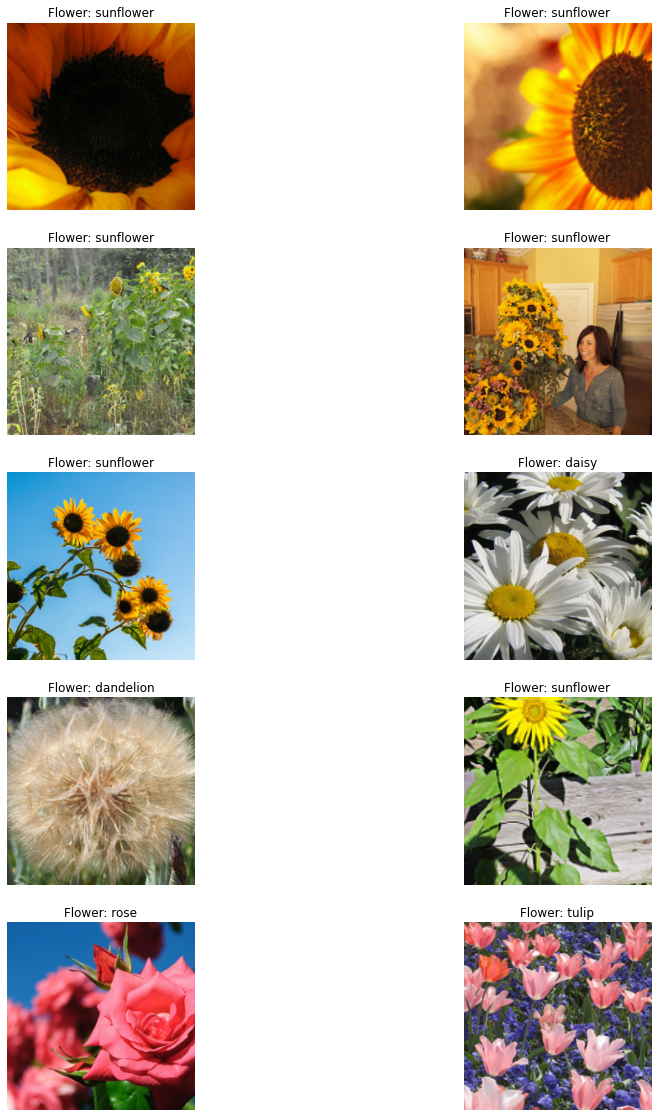

In [11]:
images, labels = next(iter(train_loader))
# any 10 random images
fig, ax = plt.subplots(5, 2)
fig.set_size_inches(15, 20)
idx = 0
for i in range(5):
    for j in range(2):
#         Convert to numpy for display
        image = images[idx].numpy()
#       Denormalize for display
        image = image / 2 + 0.5
        ax[i, j].set_axis_off()
        ax[i, j].imshow(image.transpose(1,2,0))
        ax[i, j].set_title('Flower: ' + flower_classes[labels[idx]])
        idx = idx + 1

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class Classifier(nn.Module):
    def __init__(self):
        super().__init__()
        
        #         ->224x224x3
        self.conv1 = nn.Conv2d(in_channels = 3, out_channels = 32, kernel_size = 3, stride = 1, padding = 1)
        #         ->112x112x32
        self.conv2 = nn.Conv2d(in_channels = 32, out_channels = 64, kernel_size = 3, stride = 1, padding = 1)
        #         ->56x56x64
        self.conv3 = nn.Conv2d(in_channels = 64, out_channels = 128, kernel_size = 3, stride = 1, padding = 1)
        #         ->28x28x128
        self.conv4 = nn.Conv2d(in_channels = 128, out_channels = 256, kernel_size = 3, stride = 1, padding = 1)
        #         ->14x14x256
        self.conv5 = nn.Conv2d(in_channels = 256, out_channels = 512, kernel_size = 3, stride = 1, padding = 1)
        #         ->7x7x512
        
        self.pool = nn.MaxPool2d(2, 2)
        
        self.fc1 = nn.Linear(7 * 7 * 512, 500)
        self.fc2 = nn.Linear(500, 5)
        self.dropout = nn.Dropout(p = 0.25)
        
    def forward(self, X):
        X = self.pool(F.relu(self.conv1(X)))
        X = self.pool(F.relu(self.conv2(X)))
        X = self.pool(F.relu(self.conv3(X)))
        X = self.pool(F.relu(self.conv4(X)))
        X = self.pool(F.relu(self.conv5(X)))

        X = X.view(-1, 7 * 7* 512)
        X = self.dropout(X)
        X = F.relu(self.fc1(X))
        X = self.dropout(X)
        X = self.fc2(X)
        return X

In [13]:
model = Classifier()

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

model.to(device)

cuda


Classifier(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv4): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv5): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=25088, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=5, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)

## **Adam Optimizer**

In [14]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

In [15]:
n_epochs = 20
for epoch in range(1, n_epochs + 1):
    train_loss = 0
    for X_Train, Y_Train in train_loader:
        X_Train, Y_Train = X_Train.to(device), Y_Train.to(device)
        out = model(X_Train)
        
        optimizer.zero_grad()
        loss = criterion(out, Y_Train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_Train.shape[0]
    train_loss = train_loss/len(train_loader.sampler)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, train_loss))

Epoch: 1 	Training Loss: 1.314802
Epoch: 2 	Training Loss: 1.084032
Epoch: 3 	Training Loss: 0.935451
Epoch: 4 	Training Loss: 0.901663
Epoch: 5 	Training Loss: 0.775791
Epoch: 6 	Training Loss: 0.696971
Epoch: 7 	Training Loss: 0.621837
Epoch: 8 	Training Loss: 0.490505
Epoch: 9 	Training Loss: 0.407960
Epoch: 10 	Training Loss: 0.338875
Epoch: 11 	Training Loss: 0.248063
Epoch: 12 	Training Loss: 0.198003
Epoch: 13 	Training Loss: 0.147442
Epoch: 14 	Training Loss: 0.163702
Epoch: 15 	Training Loss: 0.101473
Epoch: 16 	Training Loss: 0.097977
Epoch: 17 	Training Loss: 0.092172
Epoch: 18 	Training Loss: 0.066105
Epoch: 19 	Training Loss: 0.091194
Epoch: 20 	Training Loss: 0.069981


In [16]:
batch_size = 32
test_loss = 0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
model.eval()
for X_Test, Y_Test in test_loader:
    X_Test, Y_Test = X_Test.to(device), Y_Test.to(device)
    out = model(X_Test)
    test_loss += criterion(out, Y_Test).item() * X_Test.shape[0]
    top_p, top_class = torch.max(out, dim = 1)
    correct_tensor = top_class.eq(Y_Test.data.view_as(top_class))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(Y_Test.size(0)):
        label = Y_Test.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            flower_classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.609278

Test Accuracy of daisy: 65% (156/237)
Test Accuracy of dandelion: 73% (230/313)
Test Accuracy of  rose: 58% (142/243)
Test Accuracy of sunflower: 76% (168/221)
Test Accuracy of tulip: 63% (178/282)

Test Accuracy (Overall): 67% (874/1296)


## **SGD Optimizer**

In [17]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001)

In [18]:
n_epochs = 20
for epoch in range(1, n_epochs + 1):
    train_loss = 0
    for X_Train, Y_Train in train_loader:
        X_Train, Y_Train = X_Train.to(device), Y_Train.to(device)
        out = model(X_Train)
        
        optimizer.zero_grad()
        loss = criterion(out, Y_Train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_Train.shape[0]
    train_loss = train_loss/len(train_loader.sampler)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, train_loss))

Epoch: 1 	Training Loss: 0.009391
Epoch: 2 	Training Loss: 0.008252
Epoch: 3 	Training Loss: 0.007656
Epoch: 4 	Training Loss: 0.007264
Epoch: 5 	Training Loss: 0.006978
Epoch: 6 	Training Loss: 0.006738
Epoch: 7 	Training Loss: 0.006533
Epoch: 8 	Training Loss: 0.006347
Epoch: 9 	Training Loss: 0.006181
Epoch: 10 	Training Loss: 0.006023
Epoch: 11 	Training Loss: 0.005880
Epoch: 12 	Training Loss: 0.005742
Epoch: 13 	Training Loss: 0.005614
Epoch: 14 	Training Loss: 0.005503
Epoch: 15 	Training Loss: 0.005397
Epoch: 16 	Training Loss: 0.005298
Epoch: 17 	Training Loss: 0.005207
Epoch: 18 	Training Loss: 0.005116
Epoch: 19 	Training Loss: 0.005035
Epoch: 20 	Training Loss: 0.004956


In [19]:
batch_size = 32
test_loss = 0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
model.eval()
for X_Test, Y_Test in test_loader:
    X_Test, Y_Test = X_Test.to(device), Y_Test.to(device)
    out = model(X_Test)
    test_loss += criterion(out, Y_Test).item() * X_Test.shape[0]
    top_p, top_class = torch.max(out, dim = 1)
    correct_tensor = top_class.eq(Y_Test.data.view_as(top_class))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(Y_Test.size(0)):
        label = Y_Test.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            flower_classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.638146

Test Accuracy of daisy: 64% (154/237)
Test Accuracy of dandelion: 77% (243/313)
Test Accuracy of  rose: 51% (125/243)
Test Accuracy of sunflower: 71% (158/221)
Test Accuracy of tulip: 68% (192/282)

Test Accuracy (Overall): 67% (872/1296)


## **Adadelta Optimizer**

In [20]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adadelta(model.parameters(), lr = 0.001)

In [21]:
n_epochs = 20
for epoch in range(1, n_epochs + 1):
    train_loss = 0
    for X_Train, Y_Train in train_loader:
        X_Train, Y_Train = X_Train.to(device), Y_Train.to(device)
        out = model(X_Train)
        
        optimizer.zero_grad()
        loss = criterion(out, Y_Train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_Train.shape[0]
    train_loss = train_loss/len(train_loader.sampler)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, train_loss))

Epoch: 1 	Training Loss: 0.004858
Epoch: 2 	Training Loss: 0.004823
Epoch: 3 	Training Loss: 0.004786
Epoch: 4 	Training Loss: 0.004755
Epoch: 5 	Training Loss: 0.004721
Epoch: 6 	Training Loss: 0.004690
Epoch: 7 	Training Loss: 0.004658
Epoch: 8 	Training Loss: 0.004629
Epoch: 9 	Training Loss: 0.004599
Epoch: 10 	Training Loss: 0.004568
Epoch: 11 	Training Loss: 0.004539
Epoch: 12 	Training Loss: 0.004511
Epoch: 13 	Training Loss: 0.004482
Epoch: 14 	Training Loss: 0.004455
Epoch: 15 	Training Loss: 0.004428
Epoch: 16 	Training Loss: 0.004402
Epoch: 17 	Training Loss: 0.004374
Epoch: 18 	Training Loss: 0.004348
Epoch: 19 	Training Loss: 0.004324
Epoch: 20 	Training Loss: 0.004300


In [22]:
batch_size = 32
test_loss = 0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
model.eval()
for X_Test, Y_Test in test_loader:
    X_Test, Y_Test = X_Test.to(device), Y_Test.to(device)
    out = model(X_Test)
    test_loss += criterion(out, Y_Test).item() * X_Test.shape[0]
    top_p, top_class = torch.max(out, dim = 1)
    correct_tensor = top_class.eq(Y_Test.data.view_as(top_class))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(Y_Test.size(0)):
        label = Y_Test.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            flower_classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.651965

Test Accuracy of daisy: 65% (156/237)
Test Accuracy of dandelion: 77% (242/313)
Test Accuracy of  rose: 52% (127/243)
Test Accuracy of sunflower: 70% (156/221)
Test Accuracy of tulip: 68% (192/282)

Test Accuracy (Overall): 67% (873/1296)


## **RMSprop Optimizer**

In [23]:
import torch.optim as optim

criterion = nn.CrossEntropyLoss()
optimizer = optim.RMSprop(model.parameters(), lr = 0.001)

In [24]:
n_epochs = 20
for epoch in range(1, n_epochs + 1):
    train_loss = 0
    for X_Train, Y_Train in train_loader:
        X_Train, Y_Train = X_Train.to(device), Y_Train.to(device)
        out = model(X_Train)
        
        optimizer.zero_grad()
        loss = criterion(out, Y_Train)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * X_Train.shape[0]
    train_loss = train_loss/len(train_loader.sampler)
    print('Epoch: {} \tTraining Loss: {:.6f}'.format(
        epoch, train_loss))

Epoch: 1 	Training Loss: 0.849070
Epoch: 2 	Training Loss: 0.152016
Epoch: 3 	Training Loss: 0.032286
Epoch: 4 	Training Loss: 0.020458
Epoch: 5 	Training Loss: 0.004485
Epoch: 6 	Training Loss: 0.002592
Epoch: 8 	Training Loss: 0.002129
Epoch: 9 	Training Loss: 0.817282
Epoch: 10 	Training Loss: 0.016781
Epoch: 11 	Training Loss: 0.003470
Epoch: 12 	Training Loss: 0.001643
Epoch: 13 	Training Loss: 0.001489
Epoch: 14 	Training Loss: 0.561253
Epoch: 15 	Training Loss: 0.282042
Epoch: 16 	Training Loss: 0.006298
Epoch: 17 	Training Loss: 0.002383
Epoch: 18 	Training Loss: 0.001881
Epoch: 19 	Training Loss: 0.001697
Epoch: 20 	Training Loss: 0.001327


In [25]:
batch_size = 32
test_loss = 0
class_correct = list(0. for i in range(5))
class_total = list(0. for i in range(5))
model.eval()
for X_Test, Y_Test in test_loader:
    X_Test, Y_Test = X_Test.to(device), Y_Test.to(device)
    out = model(X_Test)
    test_loss += criterion(out, Y_Test).item() * X_Test.shape[0]
    top_p, top_class = torch.max(out, dim = 1)
    correct_tensor = top_class.eq(Y_Test.data.view_as(top_class))
    correct = np.squeeze(correct_tensor.cpu().numpy())
    for i in range(Y_Test.size(0)):
        label = Y_Test.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1
test_loss = test_loss/len(test_loader.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))
for i in range(5):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            flower_classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.943313

Test Accuracy of daisy: 64% (152/237)
Test Accuracy of dandelion: 79% (248/313)
Test Accuracy of  rose: 47% (116/243)
Test Accuracy of sunflower: 72% (161/221)
Test Accuracy of tulip: 63% (178/282)

Test Accuracy (Overall): 65% (855/1296)
